# Experiment 5: 多项式回归中的偏差-方差权衡

目标：利用Monte Carlo采样对多项式回归中的偏差，方差进行数值研究

In [217]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline##pipeline是用来简化机器学习工作流的工具
from sklearn.preprocessing import StandardScaler, PolynomialFeatures##数据标准化和多项式特征生成
from sklearn.linear_model import LinearRegression, Ridge##线性回归和岭回归（L2正则化）
from sklearn.metrics import mean_squared_error##均方误差评估指标

np.random.seed(0)

In [218]:
def f_true(x):
    return np.sin(2*np.pi*x)

In [219]:
def generate_dataset(n_samples,noise_std,rng):
    ##n_samples为样本数量，noise_std为噪声标准差，rng为随机数生成器
    X = rng.uniform(0,1,size=n_samples)
    ##在0到1之间均匀采样n_samples个点作为输入特征
    y = f_true(X) + rng.normal(0,noise_std,size=n_samples)
    ##计算对应的目标值，并添加高斯噪声，噪声均值为0，标准差为noise_std
    return X.reshape(-1,1), y
    ##输入特征被重塑为二维数组以符合scikit-learn的要求

In [220]:
rng_test=np.random.default_rng(0)##0为随机数种子
X_test=np.linspace(0,1,100).reshape(-1,1)##在0到1之间生成100个均匀分布的测试点
y_test_true=f_true(X_test).ravel()##计算测试点的真实目标值，并展平为一维数组
##X_test,y_test_true

In [221]:
def make_poly_model(degree,model_type="linear",alpha=None):
    if model_type=="linear":
        reg=LinearRegression()
    elif model_type=="ridge":
        reg=Ridge(alpha=alpha)
   
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),##多项式特征生成器，degree为多项式的最高次数，include_bias=False表示不添加偏置项
        ("scaler", StandardScaler()),##数据标准化器，将特征缩放为均值为0，方差为1的分布
        ("regressor", reg)##回归模型，可以是线性回归或岭回归
    ])

In [222]:
n_trials=100##实验重复次数
n_train=20##训练样本数量
noise_std=0.1##噪声标准差
degree=9
rng=np.random.default_rng(0)##随机数生成器

predictions=[]##存储每次实验的预测结果

for i in range(n_trials):
    X_train,y_train=generate_dataset(n_train,noise_std,rng)
    ##生成训练数据集

    model=make_poly_model(degree=degree,model_type="linear",)
    ##创建多项式线性回归模型
    model.fit(X_train,y_train)
    ##训练模型

    y_pred=model.predict(X_test)
    ##在测试集上进行预测
    predictions.append(y_pred)
    ##将预测结果添加到列表中

predictions=np.array(predictions)##转换为NumPy数组以便后续处理

In [223]:
mean_prediction=predictions.mean(axis=0)##计算每个测试点的平均预测值,
##axis=0表示沿着第一个轴（即不同实验的维度）计算均值

bias_sq=np.mean((mean_prediction-y_test_true)**2)##计算偏差平方，衡量平均预测值与真实值之间的差异
variance=np.mean((predictions-mean_prediction)**2)##计算方差，衡量预测值的波动性
noise=noise_std**2##噪声的方差，即噪声标准差的平方
mse=bias_sq+variance+noise##总均方误差

bias_sq, variance, noise, mse

(np.float64(3.1340710232152094),
 np.float64(181.31928339018313),
 0.010000000000000002,
 np.float64(184.46335441339832))

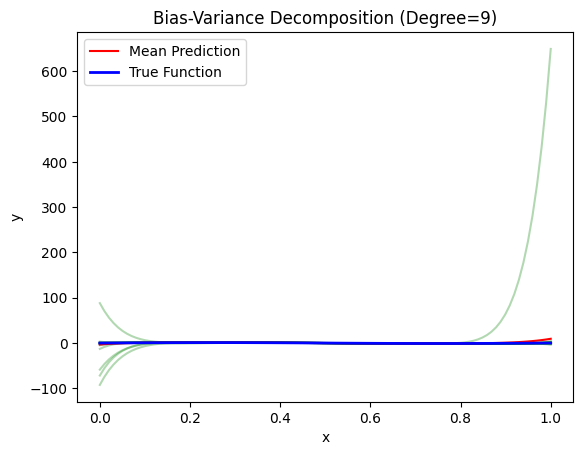

In [224]:
plt.figure()
for i in range(n_train):
    plt.plot(X_test, predictions[i], color='green', alpha=0.3)

plt.plot(X_test, mean_prediction, color='red', label='Mean Prediction')
plt.plot(X_test, y_test_true, color='blue', label='True Function',linewidth=2)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Bias-Variance Decomposition (Degree={degree})')
plt.show()

In [225]:
degree=range(1,15)
bias_list=[]
var_list=[]

for d in degree:
    preds=[]
    
    for i in range(n_trials):
        X_train,y_train=generate_dataset(n_train,noise_std,rng)
        model=make_poly_model(degree=d,model_type="linear",)
        model.fit(X_train,y_train)

        y_pred=model.predict(X_test)###在测试集上进行预测
        preds.append(y_pred)###将预测结果添加到列表中

    preds=np.array(preds)##转换为NumPy数组以便后续处理
    mean_pred=preds.mean(axis=0)##计算每个测试点的平均预测值

    bias_list.append(np.mean((mean_pred-y_test_true)**2))##计算偏差平方
    var_list.append(np.mean((preds-mean_pred)**2))##计算方差

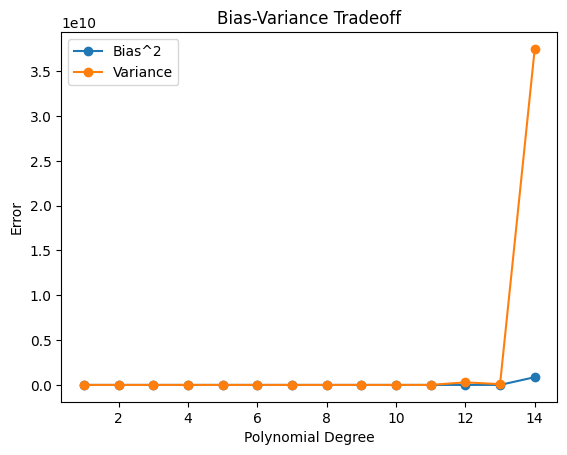

In [226]:
plt.figure()
plt.plot(degree, bias_list, marker='o', label='Bias^2')
plt.plot(degree, var_list, marker='o', label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

### 正则化部分（Ridge回归）

In [227]:
alpha=[1e-3,1e-2,1e-1,1,10]##正则化参数
degree=15

ridge_bias=[]##存储不同alpha下的偏差平方
ridge_var=[]##存储不同alpha下的方差

for a in alpha:
    preds=[]###存储每次实验的预测结果

    for i in range(n_trials):
        X_train,y_train=generate_dataset(n_train,noise_std,rng)

        model=make_poly_model(degree=degree,model_type="ridge",alpha=a)
        
        model.fit(X_train,y_train)
        preds.append(model.predict(X_test))###在测试集上进行预测

    preds=np.array(preds)##转换为NumPy数组以便后续处理
    mean_pred=preds.mean(axis=0)##计算每个测试点的平均预测值,axis简单来说就是指定计算的维度

    ridge_bias.append(np.mean((mean_pred-y_test_true)**2))##计算偏差平方
    ridge_var.append(np.mean((preds-mean_pred)**2))##计算方差
    ##.append() 就是在列表末尾添加一个元素，在这里是将每一个计算值加到相应列表的最后

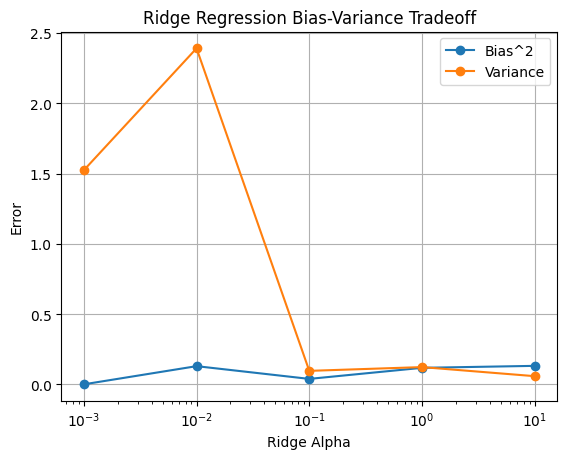

In [228]:
plt.figure()
plt.semilogx(alpha, ridge_bias, marker='o', label='Bias^2')
plt.semilogx(alpha, ridge_var, marker='o', label='Variance')
##semilogx表示x轴使用对数刻度

plt.xlabel('Ridge Alpha')
plt.ylabel('Error')
plt.title('Ridge Regression Bias-Variance Tradeoff')
plt.legend()
plt.grid()
plt.show()

In [229]:
alpha_vis=0.1
preds_vis=[]

for i in range(n_trials):
    X_train,y_train=generate_dataset(n_train,noise_std,rng)
    model=make_poly_model(degree=degree,model_type="ridge",alpha=alpha_vis)
    model.fit(X_train,y_train)
    preds_vis.append(model.predict(X_test))##predict作用是根据输入特征预测目标值
    
preds_vis=np.array(preds_vis)##转换为NumPy数组以便后续处理
mean_pred_vis=preds_vis.mean(axis=0)##计算每个测试点的平均预测值

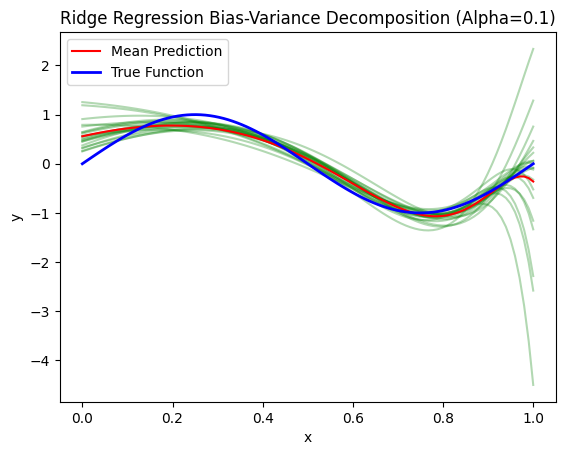

In [230]:
plt.figure()
for i in range(n_train):
    plt.plot(X_test, preds_vis[i], color='green', alpha=0.3)

plt.plot(X_test, mean_pred_vis, color='red', label='Mean Prediction')
plt.plot(X_test, y_test_true, color='blue', label='True Function',linewidth=2)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Ridge Regression Bias-Variance Decomposition (Alpha={alpha_vis})')
plt.show()

## 结论

- 增加多项式次数会显著增大方差
- 高阶线性回归将带来巨大的方差
- 岭回归通过缩小系数来降低方差，曲线明显收敛，但这种方差降低是以偏差增加为代价的